# 1.Setup:


### a. Install & Load Pkgs

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install transformers

In [ ]:
import pandas as pd
import dgl
import random
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from networkx.algorithms import centrality, cluster
import copy
import torch
import gc
from tqdm.auto import tqdm
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW
from transformers import AutoTokenizer, BertForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
from scipy.linalg import eigh
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from operator import itemgetter
from itertools import count
from functools import reduce
import pickle
import os
from scipy import stats
%matplotlib inline

### b. Download dataset
Download ZINC full dataset from From "A Generalization of Transformer Networks to Graphs" paper by Vijay Prakash Dwivedi and Xavier Bresson, 2021


In [3]:
if not os.path.isfile('zinc_full.zip'):
    print('downloading..')
    !curl https://www.dropbox.com/s/zfp10k5poe9wpf2/zinc_full.zip?dl=0 -o zinc_full.zip -J -L -k
    !unzip zinc_full.zip -d ./
else:
    print('File already downloaded')

downloading..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     65      0 --:--:-- --:--:-- --:--:--    65
100   340  100   340    0     0    509      0 --:--:-- --:--:-- --:--:--     0
100   534    0   534    0     0    492      0 --:--:--  0:00:01 --:--:--   492
100 43.6M  100 43.6M    0     0  10.9M      0  0:00:03  0:00:03 --:--:-- 16.4M
Archive:  zinc_full.zip
   creating: ./zinc_full/
  inflating: ./__MACOSX/._zinc_full  
  inflating: ./zinc_full/test.pickle  
  inflating: ./__MACOSX/zinc_full/._test.pickle  
  inflating: ./zinc_full/train.index  
  inflating: ./__MACOSX/zinc_full/._train.index  
  inflating: ./zinc_full/.DS_Store   
  inflating: ./__MACOSX/zinc_full/._.DS_Store  
  inflating: ./zinc_full/val.index   
  inflating: ./__MACOSX/zinc_full/._val.index  
  inflating: ./zinc_full/val.pickle  
  inflating: ./__MACOSX/zinc_full/._

# 2.Data Preparation



### a.Loading the data
In the data preparation phase of this project, we began by loading the original ZINC dataset as used in the Graph Transformer paper. The dataset contains molecular data structured as graphs, where each graph represents a molecule and the nodes and edges represent atoms and bonds, respectively. To ensure the reproducibility of our results, we strictly followed the original partition of the data into training, validation, and test sets according to the indices specified in the authors' GitHub repository. We then conducted a preliminary preprocessing of the data, focusing on the node (atom) and edge (bond) types. All spaces in the atom and bond type descriptions were removed to facilitate the tokenization process, and bond types were converted to lowercase. This step was crucial as it ensured that our tokenizer treats atom and bond types consistently, leading to a more robust representation of our molecular data.

In [4]:
class Dictionary:
    def __init__(self, data):
        self.data = data

# Load atom and bond dictionaries
with open('/content/zinc_full/atom_dict.pickle', 'rb') as f:
    atom_dict = pickle.load(f)
with open('/content/zinc_full/bond_dict.pickle', 'rb') as f:
    bond_dict = pickle.load(f)

atom_list = [item.replace(' ', '') for item in atom_dict.idx2word]
replacements = {'NONE': 'none', 'SINGLE': 'single', 'DOUBLE': 'double', 'TRIPLE': 'triple'}
bond_list = [reduce(lambda a, kv: a.replace(*kv), replacements.items(), item) for item in bond_dict.idx2word]

# Load train, val, and test data
with open('/content/zinc_full/train.pickle', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/zinc_full/val.pickle', 'rb') as f:
    val_data = pickle.load(f)
with open('/content/zinc_full/test.pickle', 'rb') as f:
    test_data = pickle.load(f)

# use the same train, val, and test datasets from the graphtransformer paper
with open('/content/zinc_full/test.index', 'r') as file:
    test_content = file.read()
test_idx = [int(item) for item in test_content.split(',')]
with open('/content/zinc_full/val.index', 'r') as file:
    val_content = file.read()
val_idx = [int(item) for item in val_content.split(',')]
with open('/content/zinc_full/train.index', 'r') as file:
    train_content = file.read()
train_idx = [int(item) for item in train_content.split(',')]


zink12k_test = [test_data[i] for i in test_idx]
zink12k_val = [val_data[i] for i in val_idx]
zink12k_train = [train_data[i] for i in train_idx]

# Create a dictionary to hold all your datasets
ZINCDatasets = {
    'train': zink12k_train,
    'val': zink12k_val,
    'test': zink12k_test,
}

print(atom_list)
print(bond_list)

['C', 'O', 'N', 'F', 'CH1', 'S', 'Cl', 'O-', 'NH1+', 'Br', 'NH3+', 'NH2+', 'N+', 'N-', 'S-', 'I', 'P', 'OH1+', 'NH1-', 'O+', 'S+', 'PH1', 'PH2', 'CH2-', 'P+', 'SH1+', 'CH1-', 'PH1+']
['none', 'single', 'double', 'triple']


### b.Convert to DGL
Next, we transform the raw molecular data into a format suitable for use with the Deep Graph Library (DGL).

In [ ]:
def dict_to_dgl_graph(data):
    g = dgl.graph(([], []), num_nodes=data['num_atom'])
    g.ndata['feat'] = data['atom_type'].long()
    src, dst = data['bond_type'].nonzero(as_tuple=True)
    g.add_edges(src, dst)
    g.edata['feat'] = data['bond_type'][src, dst].long()
    return g

# Dictionary to hold the results
processed_datasets = {}

# Iterate over each dataset
for set_name, dataset in ZINCDatasets.items():
    processed_list = []  # List to hold the graph dictionaries for current set
    for g in dataset:
        # Create the graph dict and DGL graph
        graph = dict_to_dgl_graph(g)
        # Append the graph and its associated label as a tuple
        processed_list.append((graph, g.get('logP_SA_cycle_normalized').item()))
    # Add the processed list to the results dictionary
    processed_datasets[set_name] = processed_list

# Now we can access your processed datasets like so:
ZINC12k_train = processed_datasets['train']
ZINC12k_val = processed_datasets['val']
ZINC12k_test = processed_datasets['test']

An illustration of a molecule graph sample:

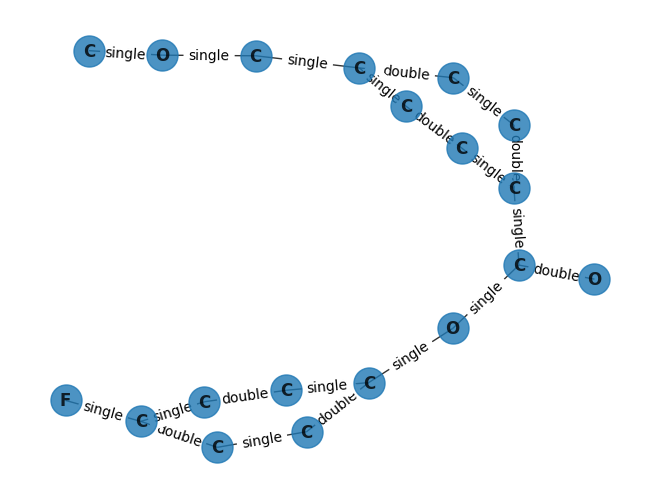

In [ ]:
graph, label = ZINC12k_val[1]
# # Convert this DGLGraph to a NetworkX graph
nx_graph = graph.to_networkx(node_attrs=['feat'], edge_attrs=['feat'])
undirected_graph = nx_graph.to_undirected()
G = nx.Graph(undirected_graph)

# Create a dictionary mapping node IDs to their labels (without index)
node_labels_dict = {i: atom_list[label] for i, label in enumerate(graph.ndata['feat'].tolist())}

# Create a dictionary mapping edge to their labels
edge_labels_dict = {(i, j): bond_list[label] for i, j, label in zip(graph.edges()[0].tolist(), graph.edges()[1].tolist(), graph.edata['feat'].tolist())}

# Set the node and edge attributes for the NetworkX graph
nx.set_node_attributes(G, node_labels_dict, 'feat')
nx.set_edge_attributes(G, edge_labels_dict, 'feat')

# Draw the networkx graph with labels
pos = nx.spring_layout(G)  # compute graph layout
nx.draw(G, pos, labels=nx.get_node_attributes(G, 'feat'), with_labels=True, node_size=500, alpha=0.8, font_weight='bold')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_dict)

plt.show()

### c.Convert DGL graph to sequence
Next, We convert our graph data into a format that can be processed by our model. For each dataset in our collection (train, validation, and test sets), we perform several operations:

Firstly, we transform the DGLGraph objects into undirected NetworkX graphs, since the molecules we're working with are essentially undirected graphs.

Next, we create mappings for the node IDs to their labels and the edges to their labels. This is done to establish a clear link between the graph structure and the respective atom and bond types. We then set these as attributes for the nodes and edges in the NetworkX graph.

The code then traverses the NetworkX graph using Depth-First Search (DFS), and for each edge visited, it retrieves the associated node and edge labels to construct a sequence that represents the graph structure.

This sequence is designed in such a way that it starts from a node, follows an edge type, and then moves to another node, thereby giving an ordered representation of the graph. This is repeated until all edges are traversed, effectively converting the graph into a sequence of tokens.

The resultant sequence is paired with the corresponding 'logP' value (the label) and added to a list. This process is done for each graph in the dataset.

Finally, this list of graph sequences and labels is converted into a pandas DataFrame for each dataset. The processed DataFrames are stored in a dictionary, allowing us to easily access the prepared data for each set: training, validation, and testing.

This process transforms our graph data into a sequential format that can be handled by sequence-based models, such as transformers

In [ ]:
results_dict = {}  # dictionary to store the results for each dataset
datasets = {"train": ZINC12k_train, "val": ZINC12k_val, "test": ZINC12k_test}

for set_name, dataset in datasets.items():
    results = []  # list to store the graph sequences with the labels for current set
    for graph, label in dataset:
        # Convert this DGLGraph to an undirected NetworkX graph
        nx_graph = graph.to_networkx(node_attrs=['feat'], edge_attrs=['feat'])
        undirected_graph = nx_graph.to_undirected()
        G = nx.Graph(undirected_graph)

        # Create a dictionary mapping node IDs to their labels
        node_labels_dict = {i: f'{i}: {atom_list[label]}' for i, label in enumerate(graph.ndata['feat'].tolist())}

        # Create a dictionary mapping edge to their labels
        edge_labels_dict = {(i, j): bond_list[label] for i, j, label in zip(graph.edges()[0].tolist(), graph.edges()[1].tolist(), graph.edata['feat'].tolist())}

        # Set the node and edge attributes for the NetworkX graph
        nx.set_node_attributes(G, node_labels_dict, 'feat')
        nx.set_edge_attributes(G, edge_labels_dict, 'feat')

        # Get edges with data as a list using DFS
        dfs_edges = list(nx.dfs_edges(G))

        graph_tokens_list = []
        # Now iterate through the sorted edges
        for idx, (u, v) in enumerate(dfs_edges):
            node0 = nx.get_node_attributes(G, 'feat')[u].split(": ")[1]
            node1 = nx.get_node_attributes(G, 'feat')[v].split(": ")[1]
            edge_type = nx.get_edge_attributes(G, 'feat')[(u,v)]

            if idx == len(dfs_edges) - 1: # if this is the last iteration
                graph_token = f" {node0} {edge_type} {node1}"
            else:
                graph_token = f" {node0} {edge_type}"

            graph_tokens_list.append(graph_token)

        # Combine all graph tokens into a single string for the graph
        graph_sequence = "".join(graph_tokens_list)
        # print(graph_sequence)

        result = {
            'graph_sequence': graph_sequence,
            'logP': label,  # Get the scalar value from the tensor
        }
        results.append(result)
    # Convert the results to a pandas DataFrame
    results_dict[set_name] = pd.DataFrame(results)

# Now we can access your processed DataFrames like so:
ZINC12kTrainDF = results_dict['train']
ZINC12kValDF = results_dict['val']
ZINC12kTestDF = results_dict['test']


In [ ]:
ZINC12kTrainDF.head()

,graph_sequence,logP
0,C single O single C double C single C double ...,0.835036
1,C single C single C single NH1+ single C sing...,-2.193549
2,C single N single C single C double C single ...,1.842230
3,C single C double C single C single N single ...,-0.711533
4,C single C single C single C single C single ...,0.246347


# 3. Dataset Statistics

The histogram provides us with crucial insights into the token lengths of our graph sequences. It helps us understand the length distribution of the sequences we're dealing with, which can be instrumental in setting the max_len parameter in our transformer configuration.

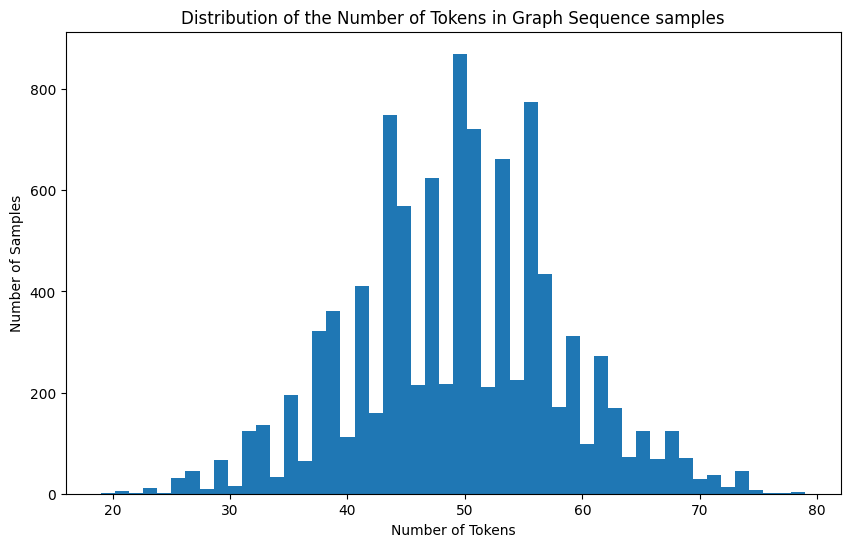

In [ ]:
# from transformers import AutoTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Compute the number of tokens in each text
num_tokens = [len(tokenizer.encode(text)) for text in ZINC12kTrainDF['graph_sequence']]

# Create a histogram of the number of tokens
plt.figure(figsize=(10, 6))
plt.hist(num_tokens, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Samples')
plt.title('Distribution of the Number of Tokens in Graph Sequence samples')
plt.show()

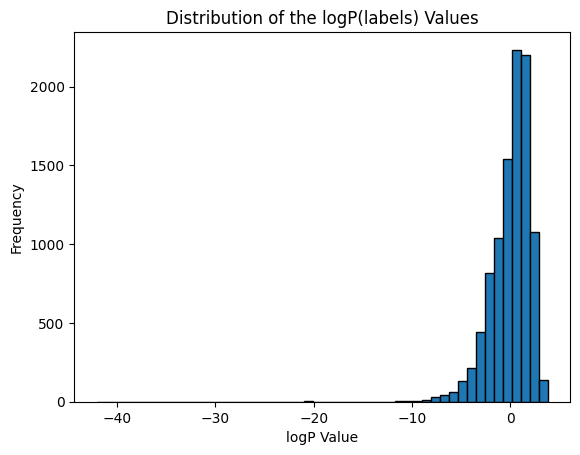

In [ ]:
plt.hist(ZINC12kTrainDF['logP'], bins=50, edgecolor='black')

plt.title('Distribution of the logP(labels) Values')
plt.xlabel('logP Value')
plt.ylabel('Frequency')

plt.show()

In this segment below, we're generating baseline models for a sanity check. By comparing the results of our main model to the baseline, we can ensure that our main model is actually learning from the data and not merely performing at random or overfitting.

In [ ]:
mean_label = ZINC12kTrainDF['logP'].mean()
median_label = ZINC12kTrainDF['logP'].median()

# Create arrays with the size of the validation/test sets filled with the mean/median
mean_preds = np.full_like(ZINC12kValDF['logP'], fill_value=mean_label)
median_preds = np.full_like(ZINC12kValDF['logP'], fill_value=median_label)

# Compute MAE for the mean and median baselines
mean_mae = mean_absolute_error(ZINC12kValDF['logP'], mean_preds)
median_mae = mean_absolute_error(ZINC12kValDF['logP'], median_preds)

print(f"Mean baseline MAE: {mean_mae}")
print(f"Median baseline MAE: {median_mae}")

Mean baseline MAE: 1.4785104238663516
Median baseline MAE: 1.4380967400622904


# 3. Model Training and Evaluation
This script below defines the main training, validation, and testing pipeline for a text classification task using the Longformer model from Hugging Face's Transformers library.

It begins by defining a custom PyTorch Dataset that accepts the text data, labels, a tokenizer, and a maximum sequence length (80) as inputs. The text is tokenized and encoded into input IDs and attention masks using the Longformer tokenizer.

The model is moved to the designated device, and the AdamW optimizer is set up with a learning rate of 1e-6. A learning rate scheduler is also created to reduce the learning rate when the validation loss stops improving, helping to avoid overfitting.

The training loop involves the forward pass, the computation of the loss, and the backward pass for gradient computation. After a certain number of steps (4, as defined by the gradient accumulation parameter), the model's parameters are updated.

Then, the model is set to evaluation mode and run through the validation set, computing the validation loss and the Mean Absolute Error (MAE) on the predicted 'logP' labels. The learning rate scheduler steps according to the validation loss. If the learning rate falls below a certain threshold, or if the training time exceeds 12 hours, the training loop breaks.

Once the training process is complete, the final model is evaluated on the test set, and the Mean Absolute Error (MAE) on the test data is reported.

Throughout the process, memory is periodically cleared to maintain efficiency.

In [ ]:
import time
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Load tokenizer and model
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=1)

# Training parameters
batch_size = 8
grad_acc_steps = 4  # Update the model every grad_acc_steps batches
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create data loaders
train_data = TextDataset(ZINC12kTrainDF['graph_sequence'], ZINC12kTrainDF['logP'], tokenizer, max_len=80)
val_data = TextDataset(ZINC12kValDF['graph_sequence'], ZINC12kValDF['logP'], tokenizer, max_len=80)
test_data = TextDataset(ZINC12kTestDF['graph_sequence'], ZINC12kTestDF['logP'], tokenizer, max_len=80)

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Move model to device and specify optimizer
model = model.to(device)
optim = AdamW(model.parameters(), lr=1e-6)

# Create learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=3, factor=0.5, min_lr=1e-8)

# Variables to store per-epoch metrics
train_loss_values = []
val_loss_values = [] # store validation loss for each epoch
val_mae_values = []

start_time = time.time() # start time of training

# Training loop
while True:
    model.train()
    total_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Update total loss
        loss.backward()

        # Gradient accumulation
        if (i + 1) % grad_acc_steps == 0 or i == len(train_loader) - 1:
            optim.step()
            optim.zero_grad()
            gc.collect()  # Run garbage collector to free up memory
            torch.cuda.empty_cache()  # Free up memory

    # After the end of each epoch, compute the average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    model.eval()
    preds, true, total_val_loss = [], [], 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()  # Update total validation loss
            preds.extend(outputs.logits.squeeze().detach().cpu().numpy())
            true.extend(labels.cpu().numpy())
            gc.collect()  # Run garbage collector to free up memory
            torch.cuda.empty_cache()  # Free up memory

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)
    val_mae = mean_absolute_error(true, preds)
    val_mae_values.append(val_mae)
    print(f'Epoch: {len(train_loss_values)}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, MAE: {val_mae}')

    # After each epoch, step the learning rate down
    scheduler.step(avg_val_loss)

    # Stop training if the learning rate has reached 1e-8 or if training has been going on for 12 hours
    if optim.param_groups[0]['lr'] <= 1e-8 or (time.time() - start_time) / 3600 >= 12:
        break

# Test
model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds.extend(outputs.logits.squeeze().detach().cpu().numpy())
        true.extend(labels.cpu().numpy())
print(f'Test MAE: {mean_absolute_error(true, preds)}')


In [ ]:
# plot the training loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# plot the validation MAE values
plt.figure(figsize=(10, 5))
plt.plot(val_mae_values)
plt.title('Validation MAE as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()